In [1]:
library(tidyverse)
library(magrittr)
library(martini)
library(cowplot)
library(snpStats)

# using read.pedfile on the GENESIS dataset
load(file = "../data/genesis/genesis.final.RData")

gene2snp <- read_tsv("../data/genesis/snp2hgnc.tsv", col_types = "cc")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: survival
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand



# Data exploration

In [2]:
summary(genesis$genotype)

$rows
   Call.rate Certain.calls Heterozygosity  
 Min.   :1   Min.   :1     Min.   :0.2663  
 1st Qu.:1   1st Qu.:1     1st Qu.:0.3138  
 Median :1   Median :1     Median :0.3161  
 Mean   :1   Mean   :1     Mean   :0.3159  
 3rd Qu.:1   3rd Qu.:1     3rd Qu.:0.3184  
 Max.   :1   Max.   :1     Max.   :0.3290  

$cols
     Calls        Call.rate Certain.calls      RAF           
 Min.   :2554   Min.   :1   Min.   :1     Min.   :0.0009789  
 1st Qu.:2554   1st Qu.:1   1st Qu.:1     1st Qu.:0.1215740  
 Median :2554   Median :1   Median :1     Median :0.3169538  
 Mean   :2554   Mean   :1   Mean   :1     Mean   :0.3799428  
 3rd Qu.:2554   3rd Qu.:1   3rd Qu.:1     3rd Qu.:0.6198121  
 Max.   :2554   Max.   :1   Max.   :1     Max.   :0.9988254  
      MAF                 P.AA             P.AB               P.BB        
 Min.   :0.0009789   Min.   :0.0000   Min.   :0.001566   Min.   :0.00000  
 1st Qu.:0.1070869   1st Qu.:0.1449   1st Qu.:0.190681   1st Qu.:0.01488  
 Median :0.2206343  

In [3]:
snpsum <- col.summary(genesis$genotype)

In [4]:
subject.info <- data.frame(cc = genesis$fam$affected, stratum = rep("EUR", nrow(genesis$fam)))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


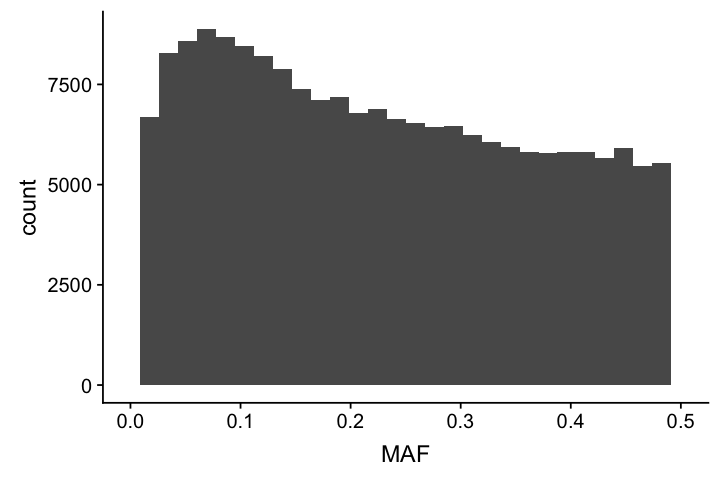

In [5]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(snpsum, aes(x = MAF)) + 
    geom_histogram() +
    lims(x = c(0, 0.5))

# GWAS

In [6]:
tests <- single.snp.tests(genesis$fam$affected, 
                          data = subject.info, 
                          snp.data = genesis$genotypes)

tests.info <- genesis$map %>%
    rename(chr = V1, gpos = V4) %>%
    mutate(p = p.value(tests, df=1),
           adjp = p.adjust(p))

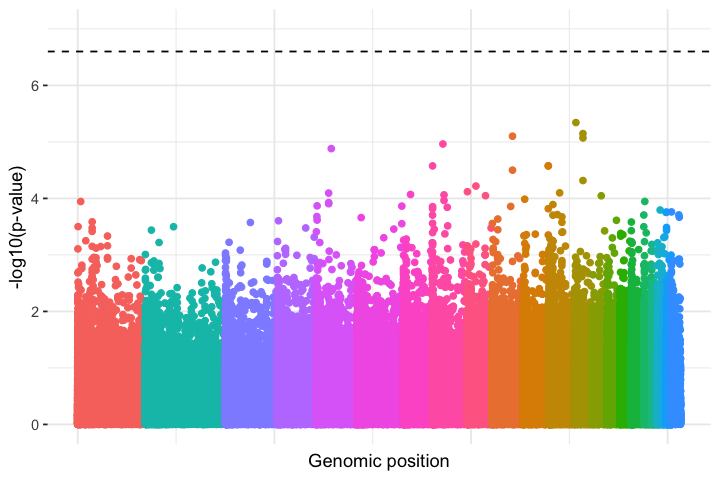

In [7]:
options(repr.plot.width=6, repr.plot.height=4)
tests.info %>% 
    mutate(abs_pos = cumsum(as.numeric(gpos))) %>%
    ggplot(aes(x = abs_pos, y = -log10(p), color = as.character(chr))) +
    geom_point() +
    geom_hline(yintercept = 6.6, linetype = 'dashed') + 
    theme_bw() +
    theme(panel.border = element_blank(),
          axis.text.x = element_blank(),
          axis.ticks.x=element_blank(),
          legend.position = "none") +
    labs(x = "Genomic position", y = "-log10(p-value)") +
    lims(y = c(0, 7))

In [8]:
# show top 10
tests.info %>%
    arrange(p) %>%
    select(chr, gpos, snp.names, p) %>%
    head(n=10)

# check those that we can map to a gene
tests.info %>%
    arrange(p) %>%
    select(chr, gpos, snp.names, p) %>%
    head(n=20) %>%
    merge(gene2snp, by.x = "snp.names", by.y = "SNP")

chr,gpos,snp.names,p
13,36366838,rs17772746,4.542354e-06
13,86249650,rs1538055,7.120317e-06
10,121132192,rs1413582,7.918198e-06
13,86269558,rs2039656,8.504100e-06
8,101285717,rs2919465,1.088515e-05
5,113929569,rs10519393,1.314141e-05
11,133305394,rs1107580,2.655261e-05
11,133305986,rs12796765,2.655261e-05
8,14226223,rs7821664,2.659716e-05
10,121139331,rs6585546,3.159281e-05


snp.names,chr,gpos,p,GENE
rs10122718,9,6999846,7.607135e-05,KDM4C
rs1107580,11,133305394,2.655261e-05,OPCML
rs11979016,7,75844438,8.513736e-05,SRRM3
rs12796765,11,133305986,2.655261e-05,OPCML
rs1413582,10,121132192,7.918198e-06,GRK5
rs1467558,11,35229673,1.032886e-04,CD44
rs16912093,9,98111370,6.039855e-05,FANCC
rs17772746,13,36366838,4.542354e-06,DCLK1
rs2919465,8,101285717,1.088515e-05,RNF19A
rs4236772,8,105185621,8.651437e-05,RIMS2


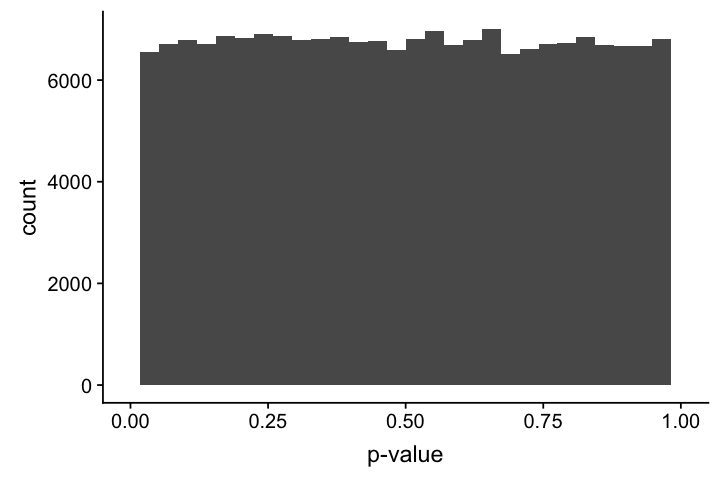

In [9]:
ggplot(tests.info, aes(x = p)) +
    geom_histogram(bins = 30) +
    lims(x = c(0,1)) +
    labs(x = "p-value")

In [10]:
bonferroni.threshold <- 0.05/nrow(genesis$map)
sum(tests.info$p < bonferroni.threshold)

[1] 0

In [11]:
sum(tests.info$adjp < 0.05)

[1] 0

# Population structure

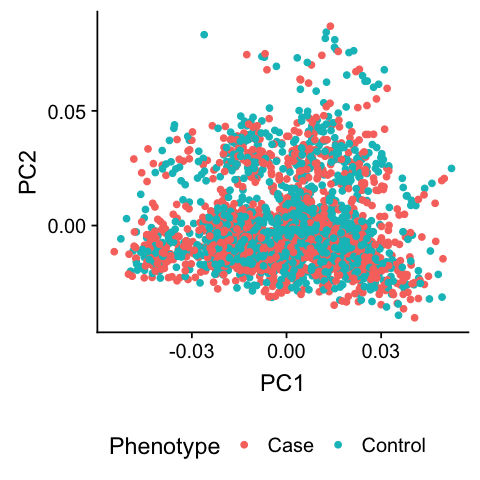

In [12]:
options(repr.plot.width=4, repr.plot.height=4)
ev <- read.delim("../results/population_structure/genesis.processed.pca.evec", 
                 sep = "", header = F, skip = 1)
ncols <- ncol(ev)
colnames(ev) <- c("sample", paste0("pc", seq(1, ncols - 2)), "phenotype")

ggplot(ev, aes(x = pc1, y = pc2, color = phenotype)) +
    geom_point() +
    labs(x = "PC1", y = "PC2", color = "Phenotype") +
    theme(legend.position = "bottom")

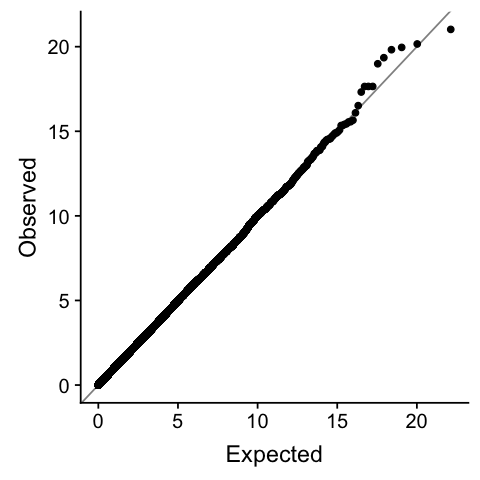

In [13]:
chi2 <- chi.squared(tests, df=1)

ggplot(as.data.frame(chi2), aes(sample = chi2)) +
    geom_qq(distribution = stats::qchisq, dparams = list(df = 1)) +
    geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
    labs(x = "Expected", y = "Observed")